In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import seaborn as sns

In [5]:
!conda install -c anaconda py-xgboost --y

Solving environment: done

## Package Plan ##

  environment location: /Users/andyjin/anaconda3

  added / updated specs:
    - py-xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  anaconda
    ca-certificates-2020.1.1   |                0         132 KB  anaconda
    certifi-2019.11.28         |           py37_0         156 KB  anaconda
    conda-4.8.3                |           py37_0         3.0 MB  anaconda
    libxgboost-0.90            |       h0a44026_1         2.4 MB  anaconda
    openssl-1.1.1d             |       h1de35cc_4         3.4 MB  anaconda
    py-xgboost-0.90            |   py37h0a44026_1          77 KB  anaconda
    ------------------------------------------------------------
                                           Total:         9.2 MB

The following NEW packages will be INSTALLED:

  _py-xgboos

In [8]:
import gc
gc.enable()

In [9]:
gc.collect()

48

## Load Data

In [2]:
train = pd.read_csv('loan_2017_hist.csv')
test = pd.read_csv('loan_2017_curr.csv')

/Users/andyjin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (118) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train.shape

(324613, 150)

In [7]:
train[:5][:5]

,id,memberid,loanamnt,fundedamnt,fundedamntinv,term,intrate,installment,grade,subgrade,...,origprojectedadditionalaccruedinterest,hardshippayoffbalanceamount,hardshiplastpaymentamount,debtsettlementflag,debtsettlementflagdate,settlementstatus,settlementdate,settlementamount,settlementpercentage,settlementterm
0,103508738,NaN,16000,16000,16000,60 months,12.74%,361.93,C,C1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,104048783,NaN,13000,13000,13000,36 months,11.44%,428.32,B,B4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,103470623,NaN,15400,15400,15400,60 months,11.39%,337.84,B,B3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,104280288,NaN,3025,3025,3025,36 months,6.99%,93.39,A,A2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,104070168,NaN,9000,9000,9000,36 months,11.39%,296.32,B,B3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324613 entries, 0 to 324612
Columns: 150 entries, id to settlementterm
dtypes: float64(56), int64(57), object(37)
memory usage: 371.5+ MB


In [59]:
df = train.append(test)
df.shape

(443139, 150)

In [60]:
cols = df.columns

## Select Data

In [61]:
all_null_feature=[]
num_feature=[]
ob_feature=[]

for col in cols:
    if df[col].isnull().sum()==df.shape[0]:
        all_null_feature.append(col)
    else:
        if df[col].dtype == 'object':
            ob_feature.append(col)
        else:
            num_feature.append(col)

In [62]:
print(all_null_feature)

['memberid', 'desc']


In [63]:
print(num_feature)

['id', 'loanamnt', 'fundedamnt', 'fundedamntinv', 'installment', 'annualinc', 'dti', 'delinq2yrs', 'ficorangelow', 'ficorangehigh', 'inqlast6mths', 'mthssincelastdelinq', 'mthssincelastrecord', 'openacc', 'pubrec', 'revolbal', 'totalacc', 'outprncp', 'outprncpinv', 'totalpymnt', 'totalpymntinv', 'totalrecprncp', 'totalrecint', 'totalreclatefee', 'recoveries', 'collectionrecoveryfee', 'lastpymntamnt', 'lastficorangehigh', 'lastficorangelow', 'collections12mthsexmed', 'mthssincelastmajorderog', 'policycode', 'annualincjoint', 'dtijoint', 'accnowdelinq', 'totcollamt', 'totcurbal', 'openacc6m', 'openactil', 'openil12m', 'openil24m', 'mthssincercntil', 'totalbalil', 'ilutil', 'openrv12m', 'openrv24m', 'maxbalbc', 'allutil', 'totalrevhilim', 'inqfi', 'totalcutl', 'inqlast12m', 'accopenpast24mths', 'avgcurbal', 'bcopentobuy', 'bcutil', 'chargeoffwithin12mths', 'delinqamnt', 'mosinoldilacct', 'mosinoldrevtlop', 'mosinrcntrevtlop', 'mosinrcnttl', 'mortacc', 'mthssincerecentbc', 'mthssincerecent

In [64]:
print(ob_feature)

['term', 'intrate', 'grade', 'subgrade', 'emptitle', 'emplength', 'homeownership', 'verificationstatus', 'issued', 'loanstatus', 'pymntplan', 'url', 'purpose', 'title', 'zipcode', 'addrstate', 'earliestcrline', 'revolutil', 'initialliststatus', 'lastpymntd', 'nextpymntd', 'lastcreditpulld', 'applicationtype', 'verificationstatusjoint', 'secappearliestcrline', 'hardshipflag', 'hardshiptype', 'hardshipreason', 'hardshipstatus', 'hardshipstartdate', 'hardshipenddate', 'paymentplanstartdate', 'hardshiploanstatus', 'debtsettlementflag', 'debtsettlementflagdate', 'settlementstatus', 'settlementdate']


In [66]:
all_null_feature=['memberid', 'desc', 'secappopenactil',
 'secappnumrevaccts',
 'secappmthssincelastmajorderog',
 'secappcollections12mthsexmed',
 'revolbaljoint',
 'secappopenacc',
 'secappficorangelow',
 'memberid',
 'secappmortacc',
 'secappearliestcrline',
 'secappchargeoffwithin12mths',
 'secapprevolutil',
 'secappficorangehigh',
 'secappinqlast6mths']

In [67]:
ob_feature=['initialliststatus',
 'grade',
 'subgrade',
 'verificationstatusjoint',
 'earliestcrline',
 'applicationtype',
 'intrate',
 'desc',
 'term',
 'homeownership',
 'addrstate',
 'revolutil',
 'zipcode',
 'verificationstatus',
 'emptitle',
 'emplength',
 'purpose',
 'issued',
 'loanstatus']

In [68]:
num_feature=['bcopentobuy',
 'numactvbctl',
 'mthssincelastrecord',
 'totcurbal',
 'mosinrcnttl',
 'openrv12m',
 'inqlast12m',
 'mortacc',
 'mthssincelastdelinq',
 'numactvrevtl',
 'tothicredlim',
 'ficorangehigh',
 'maxbalbc',
 'openil24m',
 'numbctl',
 'totalrevhilim',
 'totcollamt',
 'numtl120dpd2m',
 'totalbalexmort',
 'annualincjoint',
 'ficorangelow',
 'totalacc',
 'mthssincerecentbcdlq',
 'installment',
 'numrevaccts',
 'pubrec',
 'accopenpast24mths',
 'numoprevtl',
 'avgcurbal',
 'openactil',
 'dti',
 'openacc6m',
 'totalbalil',
 'delinq2yrs',
 'fundedamnt',
 'mosinoldilacct',
 'annualinc',
 'inqfi',
 'numtl30dpd',
 'loanamnt',
 'numsats',
 'mthssincerecentrevoldelinq',
 'mthssincerecentbc',
 'id',
 'revolbal',
 'inqlast6mths',
 'mthssincercntil',
 'openrv24m',
 'totalilhighcreditlimit',
 'collections12mthsexmed',
 'chargeoffwithin12mths',
 'numtl90gdpd24m',
 'delinqamnt',
 'mosinoldrevtlop',
 'taxliens',
 'numbcsats',
 'totalbclimit',
 'dtijoint',
 'numacctsever120pd',
 'accnowdelinq',
 'openil12m',
 'pcttlnvrdlq',
 'bcutil',
 'mthssincerecentinq',
 'numiltl',
 'mosinrcntrevtlop',
 'allutil',
 'openacc',
 'numrevtlbalgt0',
 'totalcutl',
 'mthssincelastmajorderog',
 'numtloppast12m',
 'percentbcgt75',
 'pubrecbankruptcies',
 'ilutil']

In [69]:
select_feature=ob_feature+num_feature
len(select_feature)

94

In [70]:
# remove fundedamnt since it always equals to 1 for issued loans and varied during different time of a current loan
num_feature.remove('fundedamnt')

In [71]:
# remove 'id','issued' and 'loanstatus', since they are index, train/test flag and target
num_feature.remove('id')
ob_feature.remove('loanstatus')
ob_feature.remove('issued')

In [72]:
select_feature=ob_feature+num_feature
len(select_feature)

90

In [73]:
# selected features left
df = df[select_feature+['id','loanstatus','issued']]

In [74]:
df.shape

(443139, 93)

## only use term=36 months and loanstatus = fully paid and charged off

In [75]:
df = df.query("loanstatus == 'Fully Paid' or loanstatus == 'Charged Off' ")

In [76]:
df = df.query("term ==' 36 months'")

In [77]:
df.shape

(207410, 93)

In [78]:
ob_feature.remove('term')

In [79]:
df.shape

(207410, 93)

## Label Target

In [80]:
df['loanstatus'] = df.loanstatus.map({"Charged Off": 1, "Fully Paid": 0})

In [81]:
print(df.loanstatus.value_counts())
print(df.loanstatus.value_counts(normalize=True))

0    167212
1     40198
Name: loanstatus, dtype: int64
0    0.806191
1    0.193809
Name: loanstatus, dtype: float64


## Out of time testing set and in-time training set: Oct~Dec as test)

In [82]:
issued=list(df['issued'].unique())
issued

['Mar-17',
 'Feb-17',
 'Jan-17',
 'Jun-17',
 'May-17',
 'Apr-17',
 'Sep-17',
 'Aug-17',
 'Jul-17',
 'Dec-17',
 'Nov-17',
 'Oct-17']

In [83]:
df.issued.value_counts()

Jan-17    23259
Mar-17    19583
Aug-17    19415
May-17    18265
Jun-17    17774
Jul-17    17719
Feb-17    17020
Nov-17    15677
Sep-17    15623
Oct-17    14941
Apr-17    14843
Dec-17    13291
Name: issued, dtype: int64

In [84]:
df['train_flg'] = df.issued.apply(lambda x: 0 if x in ['Oct-17','Nov-17','Dec-17'] else 1)
df.train_flg.value_counts()

1    163501
0     43909
Name: train_flg, dtype: int64

## Feature Engineering & Cleaning

#### Datetime to numeric feature

In [85]:
ob_feature

['initialliststatus',
 'grade',
 'subgrade',
 'verificationstatusjoint',
 'earliestcrline',
 'applicationtype',
 'intrate',
 'desc',
 'homeownership',
 'addrstate',
 'revolutil',
 'zipcode',
 'verificationstatus',
 'emptitle',
 'emplength',
 'purpose']

In [87]:
df.earliestcrline.unique()[:5]

array(['Apr-00', 'Aug-95', 'Oct-07', 'Apr-07', 'Apr-06'], dtype=object)

In [89]:
# convert to number of months to Dec 2017

In [90]:
cl_month=df.earliestcrline.apply(lambda x: x.split('-')[0])
cl_year=df.earliestcrline.apply(lambda x: int(x.split('-')[1]))

In [91]:
cl_month.unique()

array(['Apr', 'Aug', 'Oct', 'Jun', 'Sep', 'May', 'Dec', 'Jan', 'Mar',
       'Nov', 'Jul', 'Feb'], dtype=object)

In [92]:
cl_year.unique()

array([ 0, 95,  7,  6,  9,  5, 96, 73, 97,  1, 74, 92,  3,  4, 89, 93, 99,
        2, 94, 79, 91, 83, 88,  8, 10, 81, 90, 98, 13, 12, 85, 86, 11, 82,
       84, 80, 87, 77, 69, 66, 14, 78, 72, 68, 76, 75, 67, 65, 70, 60, 64,
       63, 71, 61, 52, 58, 53, 56, 59, 62, 57, 51, 34, 54])

In [93]:
dic_month= {'Jan':11,'Feb':10,'Mar':9,'Apr':8, 'May':7, 'Jun':6, 'Jul':5, 'Aug':4, 'Sep':3, 'Oct':2, 'Nov':1, 'Dec':0}

In [96]:
df.earliestcrline

4         Apr-00
5         Aug-95
6         Oct-07
9         Apr-07
11        Apr-06
           ...  
118496    Jan-02
118497    Nov-97
118501    Mar-92
118503    Dec-05
118504    Aug-95
Name: earliestcrline, Length: 207410, dtype: object

In [99]:
def months_till_dec_2017(date):
    year = int(date.split('-')[1])
    month = date.split('-')[0]
    
    if year < 17:
        year = 2000 + year
    else:
        year = 1900 + year
    
    return (2017 - year) * 12 + dic_month[month]

df['earliestcrline_month']=df.earliestcrline.apply(lambda x: months_till_dec_2017(x))

In [100]:
df.earliestcrline_month

4         212
5         268
6         122
9         128
11        140
         ... 
118496    191
118497    241
118501    309
118503    144
118504    268
Name: earliestcrline_month, Length: 207410, dtype: int64

In [101]:
num_feature.append('earliestcrline_month')
ob_feature.remove('earliestcrline')

In [103]:
print(len(ob_feature), len(num_feature))

15 74


### emplength to numeric feature

In [104]:
print(df['emplength'].isnull().sum())
df['emplength'].unique()

15848


array(['10+ years', '6 years', '4 years', '3 years', '1 year', nan,
       '5 years', '8 years', '2 years', '< 1 year', '9 years', '7 years'],
      dtype=object)

In [105]:
df['emplength'].replace('n/a', np.nan, inplace=True)
df['emplength'].replace('< 1 year', '0', inplace=True)
df['emplength'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df.emplength.fillna(value=-999,inplace=True)
df['emplength'] = df['emplength'].astype(int)

In [106]:
df.emplength.value_counts()

 10     65482
 2      19984
 0      19086
 3      17396
-999    15848
 1      14289
 4      13043
 5      12718
 6       9000
 7       7453
 9       6955
 8       6156
Name: emplength, dtype: int64

In [108]:
num_feature.append('emplength')
ob_feature.remove('emplength')
print(len(num_feature), len(ob_feature))

75 14


## % to numeric feature: intrate, revolutil

In [109]:
intrate=df.intrate.apply(lambda x: float(x.replace('%','')))

In [110]:
df.intrate=intrate
df.intrate[:2]

4    11.39
5     6.99
Name: intrate, dtype: float64

In [111]:
df.revolutil[:3]

4       30%
5       24%
6    44.90%
Name: revolutil, dtype: object

In [112]:
revolutil=df.revolutil.apply(lambda x: str(x).replace('%','')).astype(float)

In [113]:
df.revolutil=revolutil
df.revolutil[:2]

4    30.0
5    24.0
Name: revolutil, dtype: float64

In [114]:
ob_feature.remove('intrate')
num_feature.append('intrate')
ob_feature.remove('revolutil')
num_feature.append('revolutil')

In [116]:
print(len(ob_feature), len(num_feature))

12 77


#### Ordinal feature encoding : grade, subgrade

In [117]:
Dic_grade = {"A": 1, 
            "B": 2, 
            "C": 3, 
            "D": 4, 
            "E": 5,
            "F": 6, 
            "G": 7}

In [118]:
df.grade = df.grade.map(Dic_grade)

In [119]:
df.subgrade = df.subgrade.apply(lambda x: (Dic_grade[x[0]] - 1) * 5 + int(x[1]))

In [120]:
ob_feature.remove('grade')
num_feature.append('grade')
ob_feature.remove('subgrade')
num_feature.append('subgrade')

In [122]:
print(len(ob_feature), len(num_feature))

10 79


### High cardinality feature encoding

###### Zip Code - frequency encoding 

In [129]:
df = df[df['zipcode'].notna()]

In [130]:
print(df.zipcode.nunique(), df.zipcode.unique()[:5])

889 ['761xx' '852xx' '983xx' '021xx' '307xx']


In [131]:
# convert zipcode to int
df.zipcode = df.zipcode.apply(lambda x: int(x[0:3]))

In [132]:
df.zipcode[:5]

4     761
5     852
6     983
9      21
11    307
Name: zipcode, dtype: int64

In [133]:
zipcode_freq = df.groupby("zipcode").size().reset_index()

In [134]:
zipcode_freq[:5]

,zipcode,0
0,8,1
1,10,307
2,11,115
3,12,76
4,13,42


In [135]:
zipcode_freq.columns = ["zipcode", "zipcode_freq"]

In [136]:
df = pd.merge(df, zipcode_freq, how = "left", on = "zipcode")

In [137]:
df.zipcode_freq[:5]

0     700
1    1410
2     525
3     973
4     176
Name: zipcode_freq, dtype: int64

In [139]:
ob_feature.remove('zipcode')
num_feature.append('zipcode')
num_feature.append('zipcode_freq')
print(len(ob_feature), len(num_feature))

9 81


### emptitle-frequency encoding (can do some NLP for later stage)

In [140]:
emptitle_freq = df.groupby("emptitle").size().reset_index()
emptitle_freq.columns = ["emptitle", "emptitle_freq"]
df = pd.merge(df, emptitle_freq, how = "left", on = "emptitle")

In [142]:
ob_feature.remove('emptitle')
num_feature.append('emptitle_freq')
print(len(ob_feature), len(num_feature))

8 82


###### Addr_state - frequency encoding

In [143]:
addrstate_freq = df.groupby("addrstate").size().reset_index()
addrstate_freq.columns = ["addrstate", "addrstate_freq"]
df = pd.merge(df, addrstate_freq, how = "left", on = "addrstate")

In [144]:
ob_feature.remove('addrstate')
num_feature.append('addrstate_freq')
print(len(ob_feature), len(num_feature))

7 83


In [145]:
ob_feature

['initialliststatus',
 'verificationstatusjoint',
 'applicationtype',
 'desc',
 'homeownership',
 'verificationstatus',
 'purpose']

In [146]:
# initialliststatus has only two values, change it to 0,1
initialliststatus= df.initialliststatus.apply(lambda x: 0 if x =='w' else 1)
df.initialliststatus = initialliststatus
df.initialliststatus.value_counts()

0    143547
1     63862
Name: initialliststatus, dtype: int64

In [147]:
# applicationtype has only two values (Individual, Joint), change it to 0,1; only less than 2% is 1.
applicationtype= df.applicationtype.apply(lambda x: 0 if x =='Individual' else 1)
df.applicationtype = applicationtype 
df.applicationtype.value_counts()

0    193667
1     13742
Name: applicationtype, dtype: int64

In [149]:
ob_feature.remove('initialliststatus')
num_feature.append('initialliststatus')
ob_feature.remove('applicationtype')
num_feature.append('applicationtype')
print(len(ob_feature), len(num_feature), ob_feature)

5 85 ['verificationstatusjoint', 'desc', 'homeownership', 'verificationstatus', 'purpose']


In [151]:
# verificationstatusjoint mostly consistent with applicationtype, just remove it
ob_feature.remove('verificationstatusjoint')
print(len(ob_feature), len(num_feature), ob_feature)

4 85 ['desc', 'homeownership', 'verificationstatus', 'purpose']


In [152]:
ob_feature.remove('desc')

#### One hot encoding

In [153]:
dummy_feature = ["homeownership", "verificationstatus", "purpose"]

In [154]:
df_dummy = pd.get_dummies(df[dummy_feature])

In [155]:
OHE_feature=list(df_dummy.columns.values)

In [156]:
len(OHE_feature)

21

In [157]:
df=pd.concat([df,df_dummy], axis=1)

In [158]:
df.shape

(207409, 119)

In [159]:
for feat in dummy_feature:
    ob_feature.remove(feat)

In [160]:
len(ob_feature)

0

In [161]:
select_feature=num_feature+OHE_feature

In [162]:
len(select_feature)

106

In [163]:
df.shape

(207409, 119)

##  XGBoost 

In [164]:
feat=select_feature
print(feat)

['bcopentobuy', 'numactvbctl', 'mthssincelastrecord', 'totcurbal', 'mosinrcnttl', 'openrv12m', 'inqlast12m', 'mortacc', 'mthssincelastdelinq', 'numactvrevtl', 'tothicredlim', 'ficorangehigh', 'maxbalbc', 'openil24m', 'numbctl', 'totalrevhilim', 'totcollamt', 'numtl120dpd2m', 'totalbalexmort', 'annualincjoint', 'ficorangelow', 'totalacc', 'mthssincerecentbcdlq', 'installment', 'numrevaccts', 'pubrec', 'accopenpast24mths', 'numoprevtl', 'avgcurbal', 'openactil', 'dti', 'openacc6m', 'totalbalil', 'delinq2yrs', 'mosinoldilacct', 'annualinc', 'inqfi', 'numtl30dpd', 'loanamnt', 'numsats', 'mthssincerecentrevoldelinq', 'mthssincerecentbc', 'revolbal', 'inqlast6mths', 'mthssincercntil', 'openrv24m', 'totalilhighcreditlimit', 'collections12mthsexmed', 'chargeoffwithin12mths', 'numtl90gdpd24m', 'delinqamnt', 'mosinoldrevtlop', 'taxliens', 'numbcsats', 'totalbclimit', 'dtijoint', 'numacctsever120pd', 'accnowdelinq', 'openil12m', 'pcttlnvrdlq', 'bcutil', 'mthssincerecentinq', 'numiltl', 'mosinrcnt

### Preliminary manually parameter tuning based on stratified train-test split

In [166]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
#Kfolds = StratifiedKFold(df_all['loan_status'], n_folds = 3, shuffle=True, random_state=2019)

In [167]:
df_train = df.query("train_flg == 1")
df_test = df.query("train_flg == 0" )

In [169]:
print(df_train.shape, df_test.shape)

(163500, 119) (43909, 119)


In [170]:
df_train[feat].shape

(163500, 106)

In [171]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train[feat], df_train.loanstatus, 
                                                      test_size=0.3, random_state=2014, stratify = df_train.loanstatus )

In [172]:
X_test, y_test = df_test[feat], df_test.loanstatus

In [173]:
dtrain = xgb.DMatrix(X_train, y_train, missing = np.NAN)
dvalid = xgb.DMatrix(X_valid, y_valid, missing = np.NAN)
dtest = xgb.DMatrix(X_test, y_test, missing = np.NAN)

In [174]:
params = {"objective": "binary:logistic", 
          "booster" : "gbtree", 
          "eta": 0.05, 
          "max_depth": 6, 
          "subsample": 0.632, 
          "colsample_bytree": 0.7,
          #"colsample_bylevel": 0.6,
          "silent": 1, 
          "seed": 1234, 
          "eval_metric": "auc",
          #"gamma": 1, 
          "min_child_weight": 5} 

In [175]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
num_boost_round = 1500
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,\
  early_stopping_rounds= 50)

[0]	train-auc:0.688115	eval-auc:0.677294
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.695796	eval-auc:0.683198
[2]	train-auc:0.699923	eval-auc:0.686876
[3]	train-auc:0.702295	eval-auc:0.6883
[4]	train-auc:0.704179	eval-auc:0.691027
[5]	train-auc:0.705469	eval-auc:0.692174
[6]	train-auc:0.706209	eval-auc:0.693473
[7]	train-auc:0.70724	eval-auc:0.693804
[8]	train-auc:0.707718	eval-auc:0.694184
[9]	train-auc:0.708792	eval-auc:0.694096
[10]	train-auc:0.709418	eval-auc:0.694738
[11]	train-auc:0.71231	eval-auc:0.696899
[12]	train-auc:0.712762	eval-auc:0.697062
[13]	train-auc:0.713078	eval-auc:0.697023
[14]	train-auc:0.713531	eval-auc:0.697206
[15]	train-auc:0.713793	eval-auc:0.697279
[16]	train-auc:0.714168	eval-auc:0.697187
[17]	train-auc:0.714575	eval-auc:0.697364
[18]	train-auc:0.714972	eval-auc:0.69736
[19]	train-auc:0.715243	eval-auc:0.697656
[20]	train-auc:0.715508	eval-auc:0

[191]	train-auc:0.776289	eval-auc:0.715304
[192]	train-auc:0.776575	eval-auc:0.715305
[193]	train-auc:0.776795	eval-auc:0.715269
[194]	train-auc:0.777035	eval-auc:0.715285
[195]	train-auc:0.777358	eval-auc:0.715279
[196]	train-auc:0.777541	eval-auc:0.715301
[197]	train-auc:0.777824	eval-auc:0.715358
[198]	train-auc:0.778049	eval-auc:0.715376
[199]	train-auc:0.778307	eval-auc:0.715384
[200]	train-auc:0.778676	eval-auc:0.715449
[201]	train-auc:0.778847	eval-auc:0.715457
[202]	train-auc:0.779084	eval-auc:0.715512
[203]	train-auc:0.779421	eval-auc:0.715504
[204]	train-auc:0.779581	eval-auc:0.71551
[205]	train-auc:0.779849	eval-auc:0.715552
[206]	train-auc:0.78003	eval-auc:0.715576
[207]	train-auc:0.780204	eval-auc:0.715617
[208]	train-auc:0.780637	eval-auc:0.715655
[209]	train-auc:0.780881	eval-auc:0.715688
[210]	train-auc:0.781086	eval-auc:0.715719
[211]	train-auc:0.781311	eval-auc:0.715769
[212]	train-auc:0.781656	eval-auc:0.715796
[213]	train-auc:0.781969	eval-auc:0.715854
[214]	train-a

[383]	train-auc:0.816923	eval-auc:0.716968
[384]	train-auc:0.817103	eval-auc:0.716943
[385]	train-auc:0.81724	eval-auc:0.716909
[386]	train-auc:0.817291	eval-auc:0.716967
[387]	train-auc:0.817536	eval-auc:0.716987
[388]	train-auc:0.817836	eval-auc:0.716961
[389]	train-auc:0.817966	eval-auc:0.716926
[390]	train-auc:0.818119	eval-auc:0.716931
[391]	train-auc:0.818377	eval-auc:0.716904
[392]	train-auc:0.818471	eval-auc:0.716906
[393]	train-auc:0.818566	eval-auc:0.716961
[394]	train-auc:0.818893	eval-auc:0.716964
[395]	train-auc:0.819122	eval-auc:0.716898
[396]	train-auc:0.819244	eval-auc:0.716834
[397]	train-auc:0.819465	eval-auc:0.716877
[398]	train-auc:0.819672	eval-auc:0.716908
[399]	train-auc:0.819852	eval-auc:0.71693
[400]	train-auc:0.820064	eval-auc:0.716916
[401]	train-auc:0.820239	eval-auc:0.716948
[402]	train-auc:0.820343	eval-auc:0.71696
[403]	train-auc:0.820557	eval-auc:0.716991
[404]	train-auc:0.820866	eval-auc:0.717028
[405]	train-auc:0.821019	eval-auc:0.717015
[406]	train-au

In [176]:
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model, datasets
import pylab as pl
def draw_ROC(model, dtrain, dvalid, dtest, y_train, y_valid, y_test ):
    probas_ = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    probas_1 = model.predict(dtrain, ntree_limit=model.best_ntree_limit)
    probas_2 = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    fpr, tpr, thresholds = roc_curve(y_valid, probas_)
    fpr_1, tpr_1, thresholds_1 = roc_curve(y_train, probas_1)
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, probas_2)
    roc_auc = auc(fpr, tpr)
    roc_auc_1 = auc(fpr_1, tpr_1)
    roc_auc_2 = auc(fpr_2, tpr_2)
    print("Area under the ROC curve - validation: %f" % roc_auc)
    print("Area under the ROC curve - train: %f" % roc_auc_1)
    print("Area under the ROC curve - test: %f" % roc_auc_2)
    # Plot ROC curve
    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, label='ROC curve - valid(AUC = %0.2f)' % roc_auc, color='r')
    plt.plot(fpr_1, tpr_1, label='ROC curve - train (AUC = %0.2f)' % roc_auc_1, color='b')
    plt.plot(fpr_2, tpr_2, label='ROC curve - test (AUC = %0.2f)' % roc_auc_2, color='g')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for lead score model')
    plt.legend(loc="lower right")
    plt.show()


### ROC curve

Area under the ROC curve - validation: 0.717246
Area under the ROC curve - train: 0.813999
Area under the ROC curve - test: 0.721470


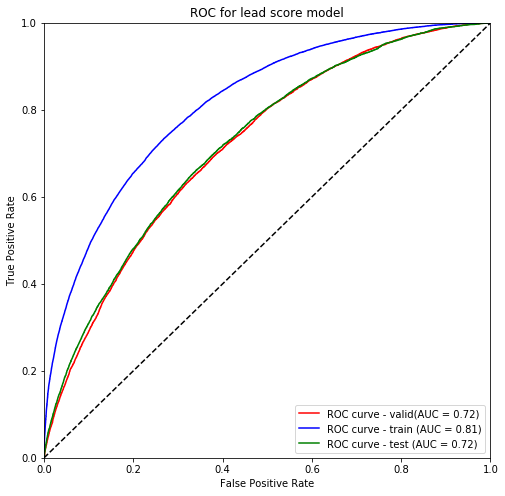

In [177]:
draw_ROC(gbm, dtrain, dvalid, dtest, y_train, y_valid, y_test)

### Distribution of predicted values

In [178]:
y_pred = gbm.predict(dtest)

In [180]:
print(y_pred.max(), y_pred.min(), y_pred.mean())

0.8521603 0.0058047604 0.18307613


### Feature importance

In [181]:
importance=gbm.get_fscore()

In [182]:
df_importance = pd.DataFrame(importance.items(), columns=['feature', 'fscore'])
df_importance['fscore'] = df_importance['fscore'] / df_importance['fscore'].sum()

In [183]:
df_importance.sort_values(['fscore'], ascending=False, inplace=True)
df_importance

,feature,fscore
25,dti,0.037590
9,installment,0.032871
10,emptitle_freq,0.028984
16,mosinoldilacct,0.028262
29,zipcode,0.027429
...,...,...
97,delinqamnt,0.000167
86,chargeoffwithin12mths,0.000111
101,purpose_renewable_energy,0.000111
98,applicationtype,0.000056


<Figure size 2304x2304 with 0 Axes>

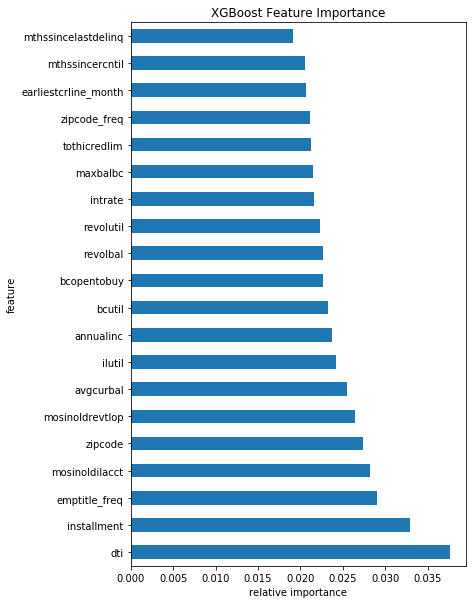

In [184]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance[:20].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

In [185]:
grade_importance = df_importance.query("feature=='grade'")
grade_importance

,feature,fscore
0,grade,0.001666


In [186]:
subgrade_importance = df_importance.query("feature=='subgrade'")
subgrade_importance

,feature,fscore
1,subgrade,0.007218


In [187]:
intrate_importance = df_importance.query("feature=='intrate'")
intrate_importance

,feature,fscore
31,intrate,0.021599


In [188]:
df_importance.query("feature=='loanamnt'")

,feature,fscore
45,loanamnt,0.017712


Text(0.5, 0, 'relative importance')

<Figure size 2304x2304 with 0 Axes>

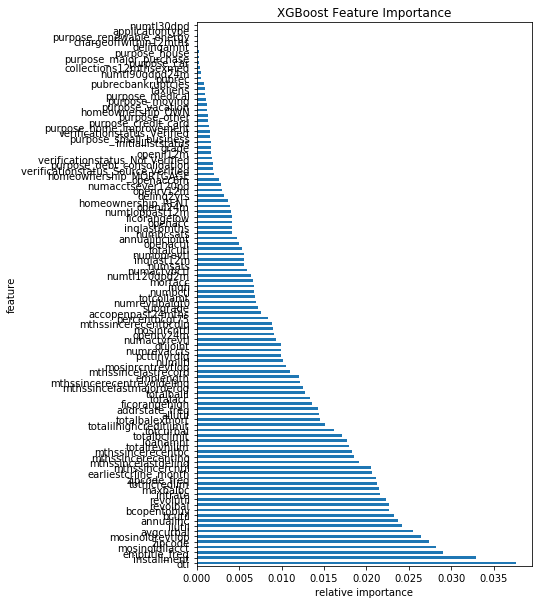

In [189]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

## Save model

In [190]:
import pickle

In [191]:
pickle.dump(gbm, open('model.pkl', "wb"))

In [192]:
from sklearn.externals import joblib
joblib.dump(gbm, "pima.joblib.dat")

/Users/andyjin/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['pima.joblib.dat']